In [1]:
import os
import time
import shlex
import subprocess
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vaex as vx
import fitsio
from astropy import units as u
from astropy.coordinates import SkyCoord
%matplotlib inline

In [2]:
# It doesn't properly work, because gets zero-filled tables
def fits2h5():
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for filename in filenm:
            if ("Y3A2_COADD_OBJECT_SUMMARY_COORDS_" in filename):
                fits_f = os.path.join(root, filename)
                h5_f = fits_f.replace(".fits", ".hdf5")
                print(h5_f)
                cmd = "vaex convert file {0} {1}".format(fits_f, h5_f)
                cmd = shlex.split(cmd)
                sp = subprocess.Popen(cmd, stdout=subprocess.PIPE)
                outp = sp.communicate()
                sp.wait()
                print(outp)


# Reading the FITS (downloaded using easyaccess)

In [3]:
# Read all tables, it took about 12min in my laptop for 4 cols, running many other tasks at the same time
# The files I get are named Y3A2_COADD_OBJECT_SUMMARY_COORDS_{000001 to 000015}.fits
def get_all(columns):
    if (not isinstance(columns, list)):
        print("Must input a list of keys")
        return False
    pattern = "Y3A2_COADD_OBJECT_SUMMARY_COORDS_"
    tabls = []
    counter = True
    t0 = time.time()
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for idx, f in enumerate(filenm):
            if (pattern in f):
                tabls.append(f)
                hdu = fitsio.FITS(f)
                if counter:
                    r_arr = hdu[1].read()[columns]
                    counter = False
                else:
                    r_arr = np.concatenate((r_arr, hdu[1].read()[columns]))
                hdu.close()
                print("{0} loaded".format(f))
    print("Elapsed time in reading the FITS: {0:.2f} min".format((time.time() - t0) / 60.))
    return r_arr

# Plot the entire(!) dataset without using healpix or pre-binning

In [ ]:
# Read into vaex. Ok, it's not optimal... better ways are read directly form FITS and h5, and from pandas
aux_all = get_all(["L", "B"])
gc.colect()

In [ ]:
ds = vx.from_arrays(x = r_arr["L"], y=r_arr["B"])
ds.plot_widget("x", "y", 
               colormap="bone_r", 
               xlabel=r"$l_{gal}$", ylabel=r"$b_{gal}$", title="2D map of all objects on the footprint Y3A2",
               limits=((0, 360), (-90, -30)),
              )

In [ ]:
# Free memory
gc.collect()
del aux_all

# Do the statistics for ra,dec -> l,b transformation

## Option 1: use vaex to plot the entire sample

In [4]:
# Load the data
arr_coo = get_all(["ALPHAWIN_J2000", "DELTAWIN_J2000", "L", "B"])

Y3A2_COADD_OBJECT_SUMMARY_COORDS_000001.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000002.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000003.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000004.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000005.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000006.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000007.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000008.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000009.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000010.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000011.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000012.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000013.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000014.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000015.fits loaded
Elapsed time in reading the FITS: 8.71 min


In [ ]:
gc.collect()

In [ ]:
# Transform it using astropy. This step is extremely slow... so it's better to go to Option 2 and 
# do it for a single file
gal = SkyCoord(ra=arr_coo["ALPHAWIN_J2000"]*u.degree, dec=arr_coo["DELTAWIN_J2000"]*u.degree, frame='icrs').galactic
print("Transformation complete")

In [ ]:
# Read into vaex
ds_gal = vx.from_arrays(L=arr_coo["L"], B=arr_coo["B"], L2=np.array(gal.l), B2=np.array(gal.b))

In [ ]:
gc.collect()
plt.close("all")

In [ ]:
# Do the plots
if False:
    ds_gal.plot([["L2", "L"], ["B2", "B"]], 
                vmin=1,
                aspect="equal",
                colormap="Spectral_r", 
                background_color='white', 
                figsize=(12,5),
                xlabel=[r"l from ($\alpha_{J2000}$, $\delta_{J2000}$)", r"b from ($\alpha_{J2000}$, $\delta_{J2000}$)"],
                ylabel=["l", "b"],
                title=r"($\alpha_{J2000}$, $\delta_{J2000}$) to ($l$, $b$). Subsample of ~2e7 objects")
    plt.savefig("lb_comparison.png", format="png", dpi=500)

    ds_gal.plot1d("B-B2", figsize=(8,5), 
                  xlabel=r"$b$ - $b_{(\alpha, \delta)}$", 
                  ylabel="N",
                  label="~2e7 objects",
                  color="red", lw=3)
    plt.savefig("b_hist.png", format="png", dpi=500)

    ds_gal.plot1d("L-L2", limits=[-0.0001,0.0001],
                  figsize=(8,5), 
                  xlabel=r"$l$ - $l_{(\alpha, \delta)}$", 
                  ylabel="N",
                  color="royalblue", lw=3)
    plt.savefig("l_hist.png", format="png", dpi=500)

## Option 2: using astropy tables, for 1 subsample

In [4]:
# Read an unique FITS with astropy tables
from astropy.io import fits
from astropy.table import Table, Column
hdu = fits.open("Y3A2_COADD_OBJECT_SUMMARY_COORDS_000015.fits")
tab = hdu[1].data
tab.names
tnew = Table()

In [5]:
# Transform
c_icrs = SkyCoord(ra=tab["ALPHAWIN_J2000"]*u.degree, dec=tab["DELTAWIN_J2000"]*u.degree, frame='icrs').galactic
print("Transformation complete")

Transformation complete


In [6]:
# Create a lighter table
arr_l, arr_b = np.array(c_icrs.l), np.array(c_icrs.b)
tnew["L"] = tab["L"]
tnew["B"] = tab["B"]
hdu.close()
tnew["L2"] = Column(arr_l, unit="degrees")
tnew["B2"] = Column(arr_b, unit="degrees")

In [7]:
# Import to vaex
ds = vx.from_astropy_table(tnew)

In [8]:
gc.collect()
plt.close("all")

/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


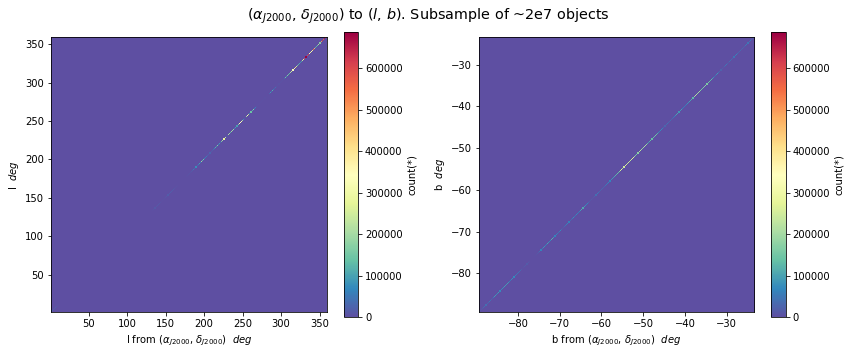

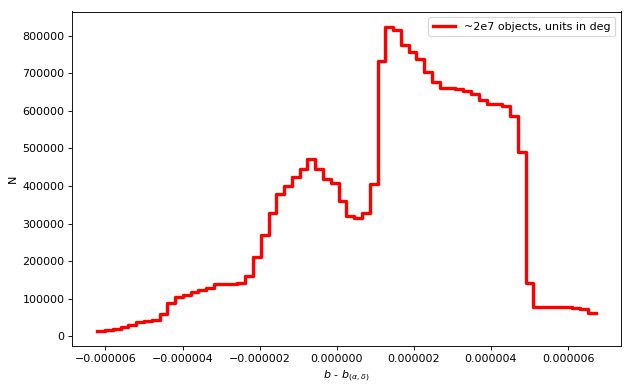

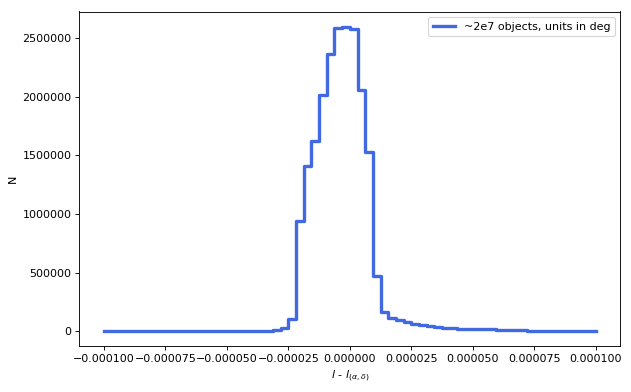

In [12]:
# Do the plots
if True:
    ds.plot([["L2", "L"], ["B2", "B"]], 
            vmin=1,
            aspect="equal",
            colormap="Spectral_r", 
            background_color='white', 
            figsize=(12,5),
            xlabel=[r"l from ($\alpha_{J2000}$, $\delta_{J2000}$)  $deg$", r"b from ($\alpha_{J2000}$, $\delta_{J2000}$)  $deg$"],
            ylabel=["l  $deg$", "b  $deg$"],
            title=r"($\alpha_{J2000}$, $\delta_{J2000}$) to ($l$, $b$). Subsample of ~2e7 objects")
    plt.savefig("lb_comparison_subsample.png", format="png", dpi=500)

    ds.plot1d("B-B2", figsize=(8,5), 
              xlabel=r"$b$ - $b_{(\alpha, \delta)}$", 
              ylabel="N",
              label="~2e7 objects, units in deg",
              color="red", lw=3)
    plt.legend()
    plt.savefig("b_hist_subsample.png", format="png", dpi=500)

    ds.plot1d("L-L2", limits=[-0.0001,0.0001],
              figsize=(8,5), 
              xlabel=r"$l$ - $l_{(\alpha, \delta)}$", 
              ylabel="N",
              label="~2e7 objects, units in deg",
              color="royalblue", lw=3)
    plt.legend()
    plt.savefig("l_hist_subsample.png", format="png", dpi=500)